# Imports

## Packages

In [65]:
import pandas as pd
import fbprophet
from fbprophet import Prophet
from dateutil.easter import easter

In [342]:
%matplotlib inline 
import numpy as np
import matplotlib.pylab as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
import glob 
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from matplotlib.pylab import rcParams
from pmdarima import auto_arima 
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import math
from scipy.stats import normaltest

In [67]:
# pip install fbprophet

import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

In [68]:
# https://github.com/facebook/prophet/issues/1300
## for the command pip install holidays==0.9.12

## Data

## File Imports

To use this notebook, download the files from https://nswtollroaddata.com under "Data Downloads" for "M1 Eastern Distibutor (ED)." Select the years 2016, 2017, 2018, 2019, 2020 separately and download each of the CSVs separately. Put them all in a folder and DO NOT include this folder name in user_directory.

In [69]:
#get user directory
user_directory = None

In [70]:
# function to get all of the files
def get_all_dataframes(path_to_data_folder):
    # give the path and this function will return all of the dataframes in a sorted list 
    original_data = glob.glob(path_to_data_folder + "/*/*/*csv",recursive=True)
    test_dataframe_list = []
    training_dataframe_list = []
    for item in original_data:
        with open(item) as f:
            df = pd.read_csv(f, parse_dates=[['Date', 'IntervalStart']], index_col = 'Date_IntervalStart')
            if "2020" in str(f):
                test_dataframe_list.append(df)
            else:
                training_dataframe_list.append(df)
    return test_dataframe_list, training_dataframe_list

In [71]:
# import files 
if user_directory != None:    #i.e.: use the directory given
    test_df_list, train_df_list = get_all_dataframes(user_directory)
else:    # point to my directory
    test_df_list, train_df_list = get_all_dataframes("./eastern_distrib")

In [72]:
len(train_df_list)

48

In [73]:
len(test_df_list)

6

In [74]:
train_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2015-12-01,ED,201602,00:14,1,Car,C,N,William Street North-bound exit ramp,-33.875924,151.217253,Ramp Gantry,6
2015-12-01,ED,201602,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,19


In [75]:
test_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2019-12-01,ED,202002,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,161
2019-12-01,ED,202002,00:14,1,Truck,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,2


# Cleaning the Dataframe

In [76]:
# function to clean the dataframe list 
def clean_dfs(dataframe_list):
    clean_dataframe_list = []
    for df in dataframe_list:
        df_C = df[df['TollPointID'] == 'C']
        df_grouped = pd.DataFrame(df_C.groupby('Date_IntervalStart').TotalVolume.sum())
        clean_dataframe_list.append(df_grouped)
    return clean_dataframe_list

In [77]:
# training dataframes
clean_train_df_list = clean_dfs(train_df_list)
# test dataframes
clean_test_df_list = clean_dfs(test_df_list)

In [78]:
clean_train_df_list[0].head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


## Combing the list dataframes into one dataframe 

In [79]:
train_df = pd.concat(clean_train_df_list)
test_df = pd.concat(clean_test_df_list)

In [80]:
train_df.head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


### Making test_df hourly

In [81]:
test_df_hourly = test_df.resample('h').sum()

In [82]:
test_df_hourly.head(2)

,TotalVolume
Date_IntervalStart,
2019-07-01 00:00:00,29
2019-07-01 01:00:00,15


In [83]:
test_df_hourly.reset_index(inplace=True)

# Using fbprophet

## Putting df in the format it requires

In [199]:
fb_prophet_train_df = train_df.resample('h').sum()

In [200]:
fb_prophet_train_df.head(2)

,TotalVolume
Date_IntervalStart,
2015-07-01 00:00:00,19
2015-07-01 01:00:00,16


In [201]:
fb_prophet_train_df.reset_index(inplace=True)

In [202]:
fb_prophet_train_df.columns = ['ds', 'y']

In [220]:
fb_prophet_train_df['ds'][1:3]

1   2015-07-01 01:00:00
2   2015-07-01 02:00:00
Name: ds, dtype: datetime64[ns]

In [221]:
type(fb_prophet_train_df['ds'][0])

pandas._libs.tslibs.timestamps.Timestamp

### First Model

In [222]:
# not sure what type the ds column should be 
## maybe it should be in datetime format, not pandas version of that 
# fb_prophet_train_df['ds'] = fb_prophet_train_df['ds'].values.astype('<M8[D]')

In [223]:
prophetfmodel = Prophet(daily_seasonality=True)

In [224]:
prophetfmodel.fit(fb_prophet_train_df)

In [225]:
one_week = 24 * 4
test_df_length = len(test_df_hourly)

In [226]:
future = prophetfmodel.make_future_dataframe(periods=test_df_length, freq='H')
future.tail()

,ds
39475,2019-12-31 19:00:00
39476,2019-12-31 20:00:00
39477,2019-12-31 21:00:00
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [227]:
forecast = prophetfmodel.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,653.026612,491.512251,834.624238
39476,2019-12-31 20:00:00,439.865587,251.569531,634.280298
39477,2019-12-31 21:00:00,250.376351,70.603778,404.759797
39478,2019-12-31 22:00:00,141.488202,-36.559916,303.203324
39479,2019-12-31 23:00:00,99.260786,-83.624632,266.237665


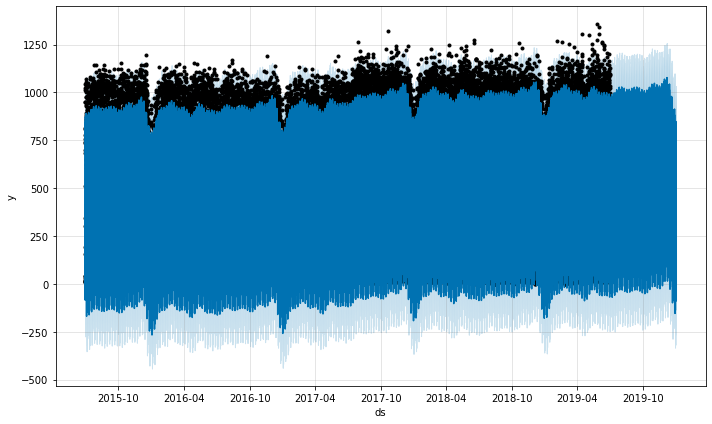

In [228]:
fig1 = prophetfmodel.plot(forecast)

### Model 2

In [348]:
fb_prophet_train_df.head(2)

,ds,y,cap,floor
0,2015-07-01 00:00:00,19,1400,0
1,2015-07-01 01:00:00,16,1400,0


In [231]:
prophetfmodel2 = Prophet(daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [232]:
prophetfmodel2.fit(fb_prophet_train_df)

In [233]:
six_month = (24 * 7)
test_df_length = len(test_df_hourly)

In [234]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future2 = prophetfmodel2.make_future_dataframe(periods=test_df_length, freq='H')
future2.tail()

,ds
39475,2019-12-31 19:00:00
39476,2019-12-31 20:00:00
39477,2019-12-31 21:00:00
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [235]:
forecast2 = prophetfmodel2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,653.026612,462.573650,835.545055
39476,2019-12-31 20:00:00,439.865587,268.446782,611.680134
39477,2019-12-31 21:00:00,250.376351,66.309331,425.946107
39478,2019-12-31 22:00:00,141.488202,-52.716108,323.244791
39479,2019-12-31 23:00:00,99.260786,-70.695340,270.967654


In [349]:
forecast2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01 00:00:00,502.842307,-108.334227,236.252034,502.842307,502.842307,-444.100945,-444.100945,-444.100945,-431.550261,...,6.552663,6.552663,6.552663,-19.103347,-19.103347,-19.103347,0.0,0.0,0.0,58.741362
1,2015-07-01 01:00:00,502.843385,-178.530442,167.758523,502.843385,502.843385,-512.933543,-512.933543,-512.933543,-501.666887,...,7.867643,7.867643,7.867643,-19.134299,-19.134299,-19.134299,0.0,0.0,0.0,-10.090158


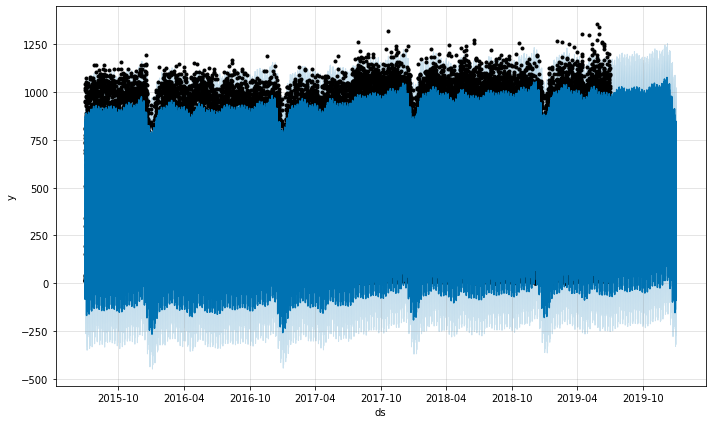

In [236]:
fig2 = prophetfmodel2.plot(forecast2)

#### Plotting Components
https://dius.com.au/2018/09/04/time-series-forecasting-with-fbprophet/

In [237]:
type(forecast2['ds'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [238]:
forecast2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01 00:00:00,502.842307,-108.334227,236.252034,502.842307,502.842307,-444.100945,-444.100945,-444.100945,-431.550261,...,6.552663,6.552663,6.552663,-19.103347,-19.103347,-19.103347,0.0,0.0,0.0,58.741362
1,2015-07-01 01:00:00,502.843385,-178.530442,167.758523,502.843385,502.843385,-512.933543,-512.933543,-512.933543,-501.666887,...,7.867643,7.867643,7.867643,-19.134299,-19.134299,-19.134299,0.0,0.0,0.0,-10.090158


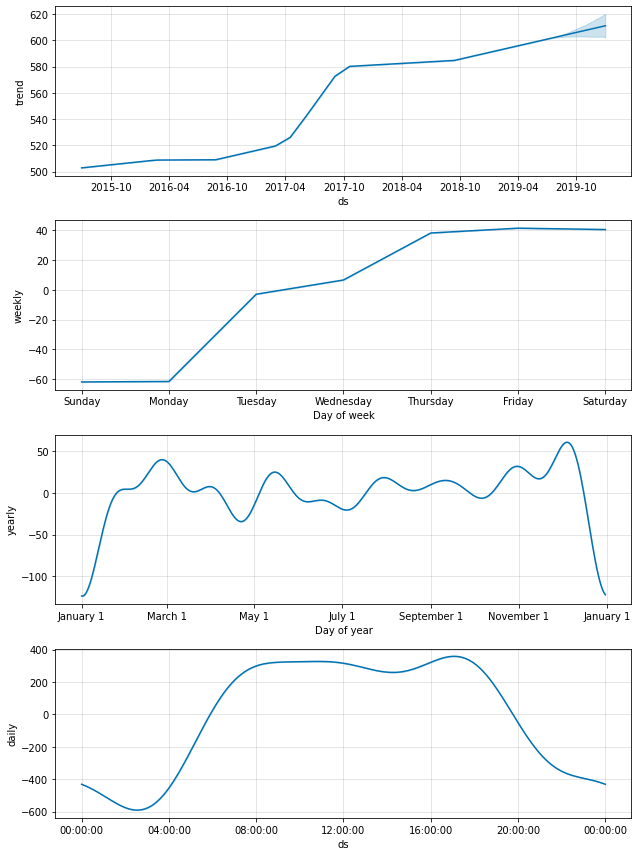

In [354]:
# prints twice unless saved as something
component_fig = prophetfmodel2.plot_components(forecast2)

In [240]:
# https://github.com/facebook/prophet/issues/1304
print(fbprophet.__version__)
print(pd.__version__)

0.5
0.25.3


### Model With Cap and Min
https://facebook.github.io/prophet/docs/saturating_forecasts.html

In [281]:
fb_prophet_train_df['cap'] = 1400
fb_prophet_train_df['floor'] = 0

In [282]:
prophetfmodel3 = Prophet(growth='logistic', daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [283]:
prophetfmodel3.fit(fb_prophet_train_df)

In [254]:
one_week = 24 * 7
test_df_length = len(test_df_hourly)

In [255]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future3 = prophetfmodel3.make_future_dataframe(periods=test_df_length, freq='H')
future3.tail(2)
future3['floor'] = 0
future3['cap'] = 1400

In [256]:
# basically same predictions as before 
forecast3 = prophetfmodel3.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,649.074415,471.503240,827.782476
39476,2019-12-31 20:00:00,435.912466,267.634558,612.346902
39477,2019-12-31 21:00:00,246.422386,79.201031,439.941542
39478,2019-12-31 22:00:00,137.533661,-27.452692,314.277168
39479,2019-12-31 23:00:00,95.305980,-95.839161,262.551857


In [351]:
len(forecast.columns)

22

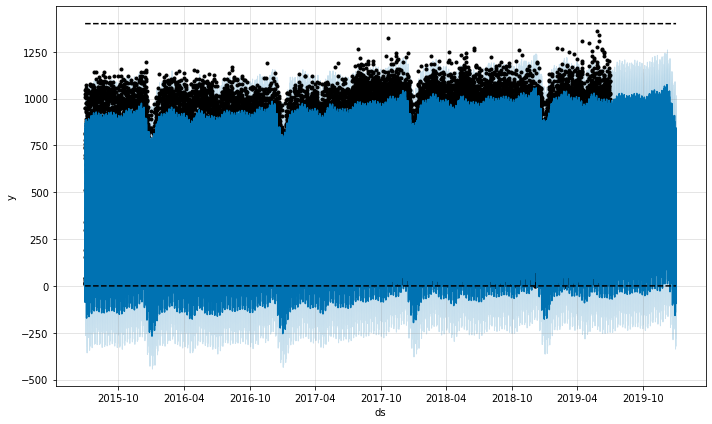

In [257]:
fig3 = prophetfmodel3.plot(forecast3)

### Model with Normalization - MinMaxScaler

In [284]:
hourly_values = fb_prophet_train_df['y'].values

In [285]:
hourly_values_reshaped = hourly_values.reshape((len(hourly_values), 1))

In [286]:
hourly_values_reshaped

array([[ 19],
       [ 16],
       [ 11],
       ...,
       [308],
       [253],
       [ 76]])

In [287]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(hourly_values_reshaped)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

Min: 0.000000, Max: 1359.000000


In [288]:
normalized = scaler.transform(hourly_values_reshaped)
for i in range(5):
    print(normalized[i])

[0.01398087]
[0.01177336]
[0.00809419]
[0.00883002]
[0.02943341]


In [289]:
train_df_days_normalized = fb_prophet_train_df.copy()

In [290]:
train_df_days_normalized['y'] = normalized

In [291]:
train_df_days_normalized.head(2)

,ds,y,cap,floor
0,2015-07-01 00:00:00,0.013981,1400,0
1,2015-07-01 01:00:00,0.011773,1400,0


In [292]:
prophetfmodel4 = Prophet(daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [293]:
prophetfmodel4.fit(train_df_days_normalized)

In [294]:
test_df_length = len(test_df_hourly)

In [295]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future4 = prophetfmodel4.make_future_dataframe(periods=test_df_length, freq='H')
future4.tail(2)

,ds
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [296]:
forecast4 = prophetfmodel4.predict(future4)
forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,0.479932,0.348495,0.610877
39476,2019-12-31 20:00:00,0.323081,0.188991,0.455392
39477,2019-12-31 21:00:00,0.183648,0.056947,0.312775
39478,2019-12-31 22:00:00,0.103524,-0.031123,0.239902
39479,2019-12-31 23:00:00,0.072452,-0.061213,0.199581


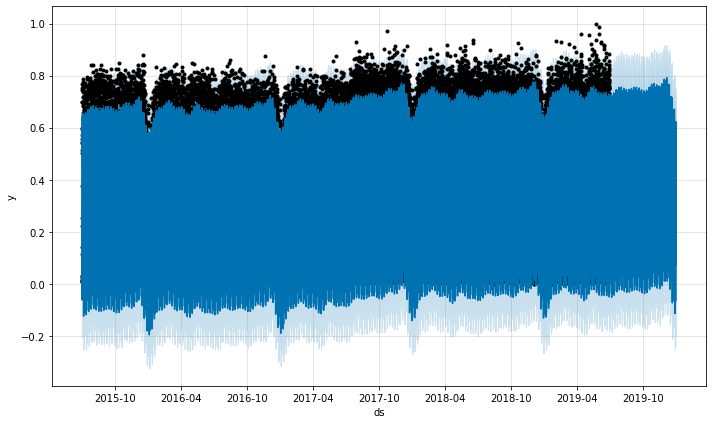

In [297]:
fig4 = prophetfmodel4.plot(forecast4)

In [298]:
# rescaled predictions
orig4_predictions = forecast4['yhat'].values
orig4_predictions_reshaped = orig4_predictions.reshape((len(orig4_predictions), 1))
forecast4_rescaled_predictions = scaler.inverse_transform(orig4_predictions_reshaped)

In [299]:
forecast4_rescaled_predictions.shape

(39480, 1)

In [300]:
forecast4_reshaped = forecast4[-39480:].copy()

In [301]:
forecast4_reshaped.shape

(39480, 22)

In [302]:
forecast4_reshaped['yhat'] = forecast4_rescaled_predictions

In [303]:
# forecast4_reshaped is sliiiiightly different than the other models

### Model with Normalization - QuantileTransformer

In [304]:
scaler2 = QuantileTransformer()
scaler2 = scaler2.fit(hourly_values_reshaped)
print(scaler2.n_quantiles_)

1000


In [305]:
normalized2 = scaler2.transform(hourly_values_reshaped)
for i in range(5):
    print(normalized2[i])

[0.06306306]
[0.04704705]
[0.02352352]
[0.02752753]
[0.14314314]


In [306]:
train_df_days_normalized2 = fb_prophet_train_df.copy()

In [307]:
train_df_days_normalized2['y'] = normalized2

In [308]:
train_df_days_normalized2.head(2)

,ds,y,cap,floor
0,2015-07-01 00:00:00,0.063063,1400,0
1,2015-07-01 01:00:00,0.047047,1400,0


In [309]:
prophetfmodel5 = Prophet(daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [310]:
prophetfmodel5.fit(train_df_days_normalized2)

In [311]:
test_df_length = len(test_df_hourly)

In [312]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future5 = prophetfmodel5.make_future_dataframe(periods=test_df_length, freq='H')
future5.tail(2)

,ds
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [313]:
forecast5 = prophetfmodel5.predict(future5)
forecast5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,0.565435,0.404275,0.724901
39476,2019-12-31 20:00:00,0.409145,0.236561,0.564301
39477,2019-12-31 21:00:00,0.288414,0.140947,0.446996
39478,2019-12-31 22:00:00,0.230197,0.075523,0.385696
39479,2019-12-31 23:00:00,0.203061,0.042366,0.361635


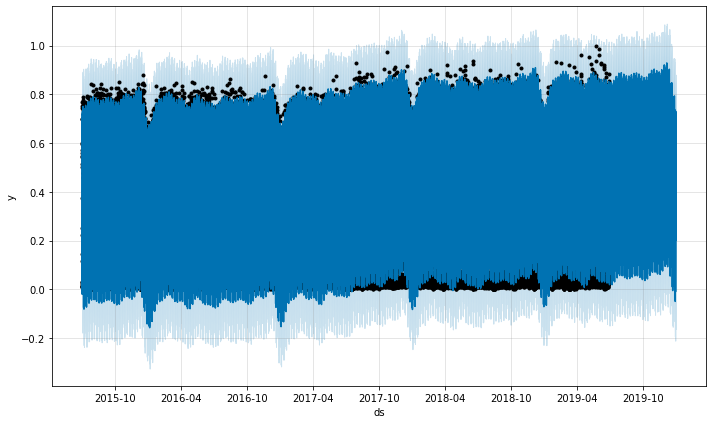

In [314]:
fig5 = prophetfmodel4.plot(forecast5)

In [315]:
# rescaled predictions
orig5_predictions = forecast5['yhat'].values
orig5_predictions_reshaped = orig5_predictions.reshape((len(orig5_predictions), 1))
forecast5_rescaled_predictions = scaler2.inverse_transform(orig5_predictions_reshaped)


In [316]:
forecast5_rescaled_predictions.shape

(39480, 1)

In [317]:
forecast5_reshaped = forecast5[-39480:].copy()

In [318]:
forecast5_reshaped.shape

(39480, 22)

In [319]:
forecast5_reshaped['yhat'] = forecast5_rescaled_predictions

In [320]:
forecast5_reshaped['yhat'].head(2)

0    36.000000
1    16.087564
Name: yhat, dtype: float64

### Standardization

#### Does the data follow a gaussian distribution

In [321]:
# sort data, then plot
sorted_num_of_cars = sorted(hourly_values)

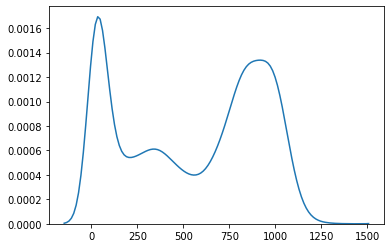

In [322]:
# not really gaussian, so this won't work
sns.kdeplot(sorted_num_of_cars)

#### Testing For Normality

In [347]:
normaltest(sorted_num_of_cars, nan_policy='omit')

NormaltestResult(statistic=205744.88876666102, pvalue=0.0)

### Power Transform

In [339]:
hourly_values_power_transform = [np.log(x) for x in hourly_values]

In [340]:
sorted_num_of_cars_power_transform = sorted(hourly_values_power_transform)

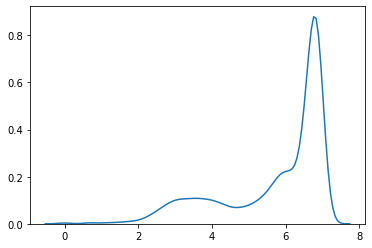

In [341]:
sns.kdeplot(sorted_num_of_cars_power_transform)

In [345]:
# since the p-value is very small, probably not from a normal distribution
## https://stackoverflow.com/questions/12838993/scipy-normaltest-how-is-it-used
normaltest(sorted_num_of_cars_power_transform, nan_policy='omit')

NormaltestResult(statistic=nan, pvalue=nan)

## Evaluating Models

### Over (almost) all of test_data

In [326]:
# model 1: incorrect time frequency (predicts hour when given 15 mins)
# model 2: linear 
# model 3: logistic 

In [327]:
test_df_length

4416

In [328]:
forecast.shape

(39480, 22)

In [329]:
39480 - 4393

35087

In [330]:
test_df_hourly['TotalVolume'].iloc[-test_df_length:-23].shape

(4393,)

In [331]:
# these models do WAAAY better over the long term
labels = ['Model1_15mins', 'Model2_lin', 'Model3_log', 'Model4_norm', 'Model5_norm2']
preds_list = [forecast[['yhat']][35087:], 
             forecast2[['yhat']][-test_df_length:-23],
             forecast3[['yhat']][-test_df_length:-23],
             forecast4_reshaped[['yhat']][-test_df_length:-23],
             forecast5_reshaped[['yhat']][-test_df_length:-23]]

for i in range(len(preds_list)):
    error = mean_squared_error(test_df_hourly['TotalVolume'].iloc[-test_df_length:-23], preds_list[i])
    print(f'{labels[i]} Error: {error:11.10}')

Model1_15mins Error:  39867.8302
Model2_lin Error: 22882.04218
Model3_log Error: 22903.96932
Model4_norm Error: 22887.42922
Model5_norm2 Error: 24298.84981


""" From our previous "Sydney_traffic" notebook
AR Error: 4111716.462
SARIMAX Error: 1517624.712"""

### over 3 week period

In [332]:
three_weeks = 24*21

In [333]:
# forecast[['ds','yhat']][138864:-three_weeks]

In [334]:
# forecast2[['ds','yhat']][-test_df_length:-(three_weeks+23)]

In [335]:
# forecast3[['yhat']][-test_df_length:-(three_weeks+23)]

In [336]:
# test_df_hourly[:3889]

In [337]:
# fbprophet models do waaaaay better 
preds_list2 = [forecast[['yhat']][35087:-three_weeks], 
             forecast2[['yhat']][-test_df_length:-(three_weeks+23)],
             forecast3[['yhat']][-test_df_length:-(three_weeks+23)],
             forecast4_reshaped[['yhat']][-test_df_length:-(three_weeks+23)],
              forecast5_reshaped[['yhat']][-test_df_length:-(three_weeks+23)]]

for i in range(len(preds_list2)):
    error = mean_squared_error(test_df_hourly['TotalVolume'][:3889], preds_list2[i])
    print(f'{labels[i]} Error: {error:11.10}')

Model1_15mins Error: 40489.67552
Model2_lin Error: 22331.86082
Model3_log Error: 22347.41057
Model4_norm Error: 22336.00083
Model5_norm2 Error: 23380.12718


""" From our previous "Sydney_traffic" notebook
ARnolag Error: 68322.47476
AR Error:   58524.534
ARMA Error: 144629.2036
SARIMAX Error: 150113.7128
SARIMAX_SEASONAL Error: 150113.7128"""

### Removing any negative yhat values

In [338]:
# am I allowed to do this? We know beforehand that there can't be a negative amount of drivers on the road...
## yes: https://stackoverflow.com/questions/55079109/negative-values-in-time-series-forecast
